In [137]:
import collections

In [77]:
import sys
import numpy as np

from astropy import units as u
from astropy import table, modeling

from scipy import stats

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import __version__ as mpl_vers
mpl_vers

'3.0.0'

In [3]:
pathtoinsert = '..'  # should have emceemr
if pathtoinsert not in sys.path:
    sys.path.insert(1, pathtoinsert)

import emceemr

In [4]:
import inspect

In [5]:
inspect.getmro(modeling.models.Gaussian1D)

(<class 'astropy.modeling.functional_models.Gaussian1D'>
Name: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Fittable parameters: ('amplitude', 'mean', 'stddev'),
 <class 'astropy.modeling.core.Fittable1DModel'>,
 <class 'astropy.modeling.core.FittableModel'>,
 <class 'astropy.modeling.core.Model'>,
 object)

In [61]:
class ProbabilisticModel(modeling.Model):
    pass

class Test1(ProbabilisticModel, modeling.models.Gaussian1D):
    _inherit_descriptors_ = (modeling.Parameter,)
    proby = modeling.Parameter(default=0.5)
    
class Test2(modeling.models.Gaussian1D, ProbabilisticModel):
    _inherit_descriptors_ = (modeling.Parameter,)
    proby = modeling.Parameter(default=0.5)

Test1._parameters_, Test2._parameters_

(OrderedDict([('proby', Parameter('proby', default=0.5))]),
 OrderedDict([('amplitude', Parameter('amplitude', default=1)),
              ('mean', Parameter('mean', default=0)),
              ('stddev',
               Parameter('stddev', default=1, bounds=(1.1754943508222875e-38, None))),
              ('proby', Parameter('proby', default=0.5))]))

In [62]:
class ProbabilisticModel(modeling.Model):
    _inherit_descriptors_ = (modeling.Parameter,)

class Test1(ProbabilisticModel, modeling.models.Gaussian1D):
    proby = modeling.Parameter(default=0.5)
    
class Test2(modeling.models.Gaussian1D, ProbabilisticModel):
    proby = modeling.Parameter(default=0.5)

Test1._parameters_, Test2._parameters_

(OrderedDict([('amplitude', Parameter('amplitude', default=1)),
              ('mean', Parameter('mean', default=0)),
              ('stddev',
               Parameter('stddev', default=1, bounds=(1.1754943508222875e-38, None))),
              ('proby', Parameter('proby', default=0.5))]),
 OrderedDict([('amplitude', Parameter('amplitude', default=1)),
              ('mean', Parameter('mean', default=0)),
              ('stddev',
               Parameter('stddev', default=1, bounds=(1.1754943508222875e-38, None))),
              ('proby', Parameter('proby', default=0.5))]))

In [63]:
class ProbabilisticModel(modeling.Model):
    _inherit_descriptors_ = (modeling.Parameter,)
    
    
    

Base API: ProbabilisticModel should have a mean model and a noise model.

Noise Model should take the mean model + data and output a log-prob of the same shape as the mean model output.  Form can be one of
 * modeling model that returns log-prob given whole mean-model (one of the parameters is the mean-model part)?
 * modeling model that returns prob given whole mean-model (one of the parameters is the mean-model part)?
 * scipy.stats probability distribution. need to figure out how to get parameters...
 * callable that takes in log-prob
    
For experimentation, use a linear mean model and gaussian noise model

In [76]:
mean_model = modeling.models.Linear1D(slope=2, intercept=1)

Need to make the log-prob model:

In [237]:
def generate_logpdfmodel_class(frozen_distribution, scale_param_name='prob_scale', location_param_name='prob_loc', data_param_name='prob_loc'):
    dist = frozen_distribution.dist
    other_params, loc, scale = dist._parse_args(*frozen_distribution.args, **frozen_distribution.kwds)
    other_param_names = [] if dist.shapes is None else dist.shapes.split(', ')

    assert len(other_params) == len(other_param_names), 'This stats object seems messed up - the names of the parameters do not match the number of parameters'

    # order matters here!  most go "other parameters in order, loc, scale"
    params = []
    for nm, p in zip(other_param_names, other_params):
        params.append(modeling.Parameter(name=nm, default=p))
    params.append(modeling.Parameter(name=location_param_name, default=loc, description='distribution location parameter'))
    params.append(modeling.Parameter(name=scale_param_name, default=scale, description='distribution scale parameter'))

    params = collections.OrderedDict(((p.name, p) for p in params))
    
    members = {}
    
    def tester(*args, **kwargs):
        print(args, kwargs)
        return dist.logpdf(*args, **kwargs)
        
    
    mod = find_current_module(1)
    modname = mod.__name__ if mod else '__main__'
    
    members = {
        '__module__': str(modname),
        'distribution': dist,
        'inputs': ('x',),
        'outputs': ('logpdf',),
        'evaluate': staticmethod(dist.logpdf),
    }
    members.update(params)
    
    return type(dist.name.title() + 'LogPDFModel', (modeling.FittableModel,), members)
    
    
Mod = generate_logpdfmodel_class(stats.beta(1,2, scale=3))
Mod

<class '__main__.BetaLogPDFModel'>
Name: BetaLogPDFModel
Inputs: ('x',)
Outputs: ('logpdf',)
Fittable parameters: ('a', 'b', 'prob_loc', 'prob_scale')

In [240]:
mod = Mod()
mod(1), stats.beta.logpdf(1, 1, 2, scale=3)

(-0.8109302162163288, -0.8109302162163288)

In [257]:
Mod2 = generate_logpdfmodel_class(stats.norm(scale=1), scale_param_name='sigma')
Mod2

<class '__main__.NormLogPDFModel'>
Name: NormLogPDFModel
Inputs: ('x',)
Outputs: ('logpdf',)
Fittable parameters: ('prob_loc', 'sigma')

In [258]:
mod = Mod2(prob_loc=[0, 1])
mod(0)

array([-0.91893853, -1.41893853])

Now try the core functionality

In [266]:
noise_model_class = generate_logpdfmodel_class(stats.norm(), location_param_name='mu', scale_param_name='sigma')
noise_model_class

<class '__main__.NormLogPDFModel'>
Name: NormLogPDFModel
Inputs: ('x',)
Outputs: ('logpdf',)
Fittable parameters: ('mu', 'sigma')

In [268]:
noise_model = noise_model_class()
noise_model

<NormLogPDFModel(mu=0., sigma=1.)>

In [272]:
combined_model(-.5)

-0.9189385332046727

That's not quite right because the model is going in as the *input* not the mean...

In [284]:
combined_model = (mean_model & modeling.models.Identity(1)) | noise_model
combined_model

ModelDefinitionError: Unsupported operands for |: None (n_inputs=2, n_outputs=2) and None (n_inputs=1, n_outputs=1); n_outputs for the left-hand model must match n_inputs for the right-hand model.

In [445]:
def generate_logpdfmodel_class(frozen_distribution,
                               scale_param_name='prob_scale',
                               location_param_name='prob_loc',
                               mean_model_param_name=None):
    """
    mean_model_param_name = None means "whatever the location parameter is"
    """
    if mean_model_param_name is None:
        mean_model_param_name = location_param_name
    

    dist = frozen_distribution.dist
    other_params, loc, scale = dist._parse_args(*frozen_distribution.args, **frozen_distribution.kwds)
    other_param_names = [] if dist.shapes is None else dist.shapes.split(', ')

    assert len(other_params) == len(other_param_names), 'This stats object seems messed up - the names of the parameters do not match the number of parameters'

    # order matters here!  most go "other parameters in order, loc, scale"
    params = []
    for nm, p in zip(other_param_names, other_params):
        params.append(modeling.Parameter(name=nm, default=p))
    params.append(modeling.Parameter(name=location_param_name, default=loc, description='distribution location parameter'))
    params.append(modeling.Parameter(name=scale_param_name, default=scale, description='distribution scale parameter'))

    params = collections.OrderedDict(((p.name, p) for p in params if p.name != mean_model_param_name))

    mod = find_current_module(2)
    modname = mod.__name__ if mod else '__main__'

    def log_pdf_with_meanmodel(*args):
        kwargs = dict(zip(params.keys(), args[2:]))
        kwargs[mean_model_param_name] = args[0]
        kwargs['loc'] = kwargs.pop(location_param_name)
        kwargs['scale'] = kwargs.pop(scale_param_name)
        return dist.logpdf(args[1], **kwargs)

    members = {
        '__module__': str(modname),
        'distribution': dist,
        'inputs': ('mean_model_result', 'data'),
        'outputs': ('logpdf',),
        'evaluate': staticmethod(log_pdf_with_meanmodel),
    }
    members.update(params)

    return type(dist.name.title() + 'LogPDFModel', (modeling.FittableModel,), members)


noise_model_class = generate_logpdfmodel_class(stats.norm(scale=3), location_param_name='mu', scale_param_name='sigma')
noise_model = noise_model_class()
noise_model, noise_model.inputs

(<NormLogPDFModel(sigma=3.)>, ('mean_model_result', 'data'))

In [435]:
combined_model = (mean_model & modeling.models.Identity(1)) | noise_model
combined_model

<CompoundModel31(slope_0=2., intercept_0=1., sigma_2=3.)>

array([-2.34267499, -4.57966261, -2.20401517, -2.29015737, -2.26892684,
       -2.15415056, -2.46169289, -2.02375236, -3.12894326, -4.49454868,
       -2.0217792 , -2.32510766, -2.13282006, -2.056245  , -2.01896156,
       -2.03757629, -5.88981613, -2.72974624, -2.19190655, -3.1453294 ,
       -2.10527021, -2.16968605, -2.02178052, -2.03746201, -2.14779728,
       -2.03132216, -2.05864648, -2.01868587, -2.61030774, -3.02905464,
       -2.24851089, -2.89540211, -2.04513161, -2.08988475, -2.16508251,
       -2.11800775, -2.06469794, -2.85593064, -2.12104276, -2.11385576,
       -2.23298951, -2.02039691, -2.25548736, -2.02548182, -2.04734421,
       -2.26911363, -2.06577932, -2.24251054, -2.85190064, -2.21274229,
       -2.23825484, -2.01870975, -2.35905875, -2.03295247, -2.71184412,
       -3.33013869, -2.03413908, -2.10370171, -2.04117491, -2.14883203,
       -2.39110397, -2.05842501, -2.04228434, -2.19680813, -3.6055882 ,
       -2.13061048, -2.18768396, -2.36305862, -2.46229406, -2.01

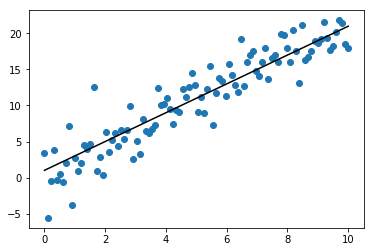

In [479]:
example_x = np.linspace(0, 10, 100)
example_y = noise_model.distribution.rvs(loc=mean_model(example_x), scale=noise_model.sigma)

plt.scatter(example_x, example_y)
plt.plot(example_x, mean_model(example_x),c='k')

combined_model(example_x, example_y)

This composition leads to awkward model names, and working with the distribution is rather challenging.  Maybe generate a new model class in the same way, and get frozen distributions on demand? But that's a substantial re-work, best done in a new notebook.

# Aside: for what n does function call overhead dominate? 

n= 1
3.48 µs ± 30.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 2
3.58 µs ± 28.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5
3.52 µs ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 10
3.56 µs ± 43.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 20
3.52 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 50
3.58 µs ± 48.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 100
3.62 µs ± 34.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 200
4.24 µs ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 500
4.88 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 1000
6.7 µs ± 359 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5000
13.8 µs ± 390 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 10000
26.3 µs ± 503 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
n= 50000
127 µs ± 4.18 µs p

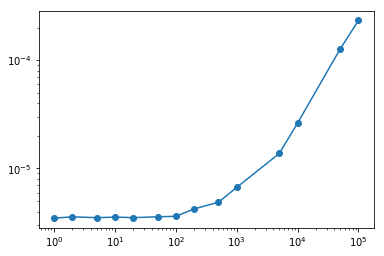

In [373]:
def f(a):
    return (a + 100)*12.3

def g(b):
    return f(b) + b*2.3

ns = []
times = []
for n in (1, 2, 5, 10, 20, 50, 100,200, 500, 1000,5000, 10000, 50000, 100000):
    print('n=', n)
    a = np.random.randn(n)
    res = %timeit -o g(a)
    ns.append(n)
    times.append(res.average)
plt.loglog(ns, times, 'o-')

n= 1
3.8 µs ± 84.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 2
3.9 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5
3.7 µs ± 34.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 10
3.73 µs ± 42 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 20
3.74 µs ± 62.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 50
3.76 µs ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 100
3.84 µs ± 69.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 200
4.39 µs ± 59.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 500
4.87 µs ± 72.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 1000
6.01 µs ± 56.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5000
13.4 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 10000
25 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
n= 50000
137 µs ± 3.23 µs per l

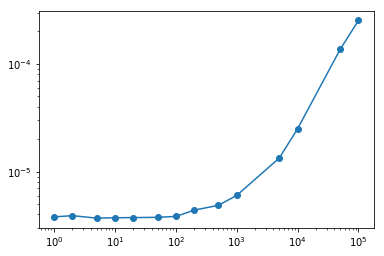

In [375]:
def f(a):
    return (a + 100)*12.3

def g(b):
    return f(b) + b*2.3

def h(c):
    return g(c)

ns = []
times = []
for n in (1, 2, 5, 10, 20, 50, 100,200, 500, 1000,5000, 10000, 50000, 100000):
    print('n=', n)
    a = np.random.randn(n)
    res = %timeit -o h(a)
    ns.append(n)
    times.append(res.average)
plt.loglog(ns, times, 'o-')

n= 1
4.51 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 2
4.36 µs ± 148 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5
4.19 µs ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 10
4.46 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 20
4.38 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 50
4.81 µs ± 79.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 100
4.9 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 200
5.94 µs ± 82.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 500
7.33 µs ± 392 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 1000
10.4 µs ± 458 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
n= 5000
29.1 µs ± 629 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
n= 10000
1.67 ms ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
n= 50000
2.36 ms ± 80.1 µs per lo

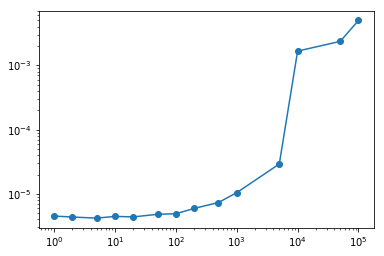

In [374]:
def f(a):
    return (a + 100)*12.3

def g(b):
    return np.exp(f(b) + b*2.3)

ns = []
times = []
for n in (1, 2, 5, 10, 20, 50, 100,200, 500, 1000,5000, 10000, 50000, 100000):
    print('n=', n)
    a = np.random.randn(n)
    res = %timeit -o g(a)
    ns.append(n)
    times.append(res.average)
plt.loglog(ns, times, 'o-')

The ones below are a bit more complex in that it has a programatically set of nested calls

In [423]:
def f(a):
    return (a + 100)*12.3

def noop():
    pass

def g(b, ncalls=1):
    out = f(b)
    for i in range(ncalls-1):
        noop()
    return out

ncalls = 1 narray = 10
2.78 µs ± 356 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 20
2.77 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 50
2.67 µs ± 193 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 100
3.05 µs ± 644 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 200
2.97 µs ± 343 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 500
3.12 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 1000
4.7 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 2000
4.52 µs ± 581 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 5000
7.37 µs ± 448 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 10000
11.7 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 1024 loops each)
ncalls = 1 narray = 20000
30.4 µs ± 45

(2.2759970866228052e-06, 7.42879727989769e-05)

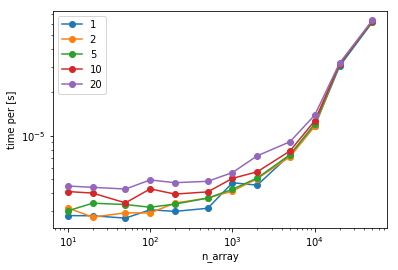

In [429]:
ncalls = []
ns = []
times = []
for ncall in (1, 2, 5, 10, 20):
    for n in (10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000, 20000, 50000):
        print('ncalls =',ncall, 'narray =', n)
        a = np.random.randn(n)
        res = %timeit -r 7 -n 1024 -o g(a, ncalls=ncall)
        ncalls.append(ncall)
        ns.append(n)
        times.append(res.average)
        
ns = np.array(ns)
ncalls = np.array(ncalls)
times = np.array(times)
un = np.unique(ncalls)
for ui in un:
    msk = ncalls == ui
    plt.loglog(ns[msk], times[msk], 'o-', label=ui)
plt.legend(loc=0)
plt.xlabel('n_array')
plt.ylabel('time per [s]')
plt.ylim()